<a href="https://colab.research.google.com/github/RyanHwang81/my_stock_app/blob/main/US%EC%9C%A0%EB%8F%99%EC%84%B1%20%EC%A7%80%ED%91%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

데이터를 불러오는 중입니다... 잠시만 기다려주세요.


/tmp/ipython-input-1495948967.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').last().ffill()
/tmp/ipython-input-1495948967.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  z_score(df['RealYield'].fillna(method='bfill')) +


✅ 차트가 'Liquidity_Index_Latest.png' 파일로 저장되었습니다.


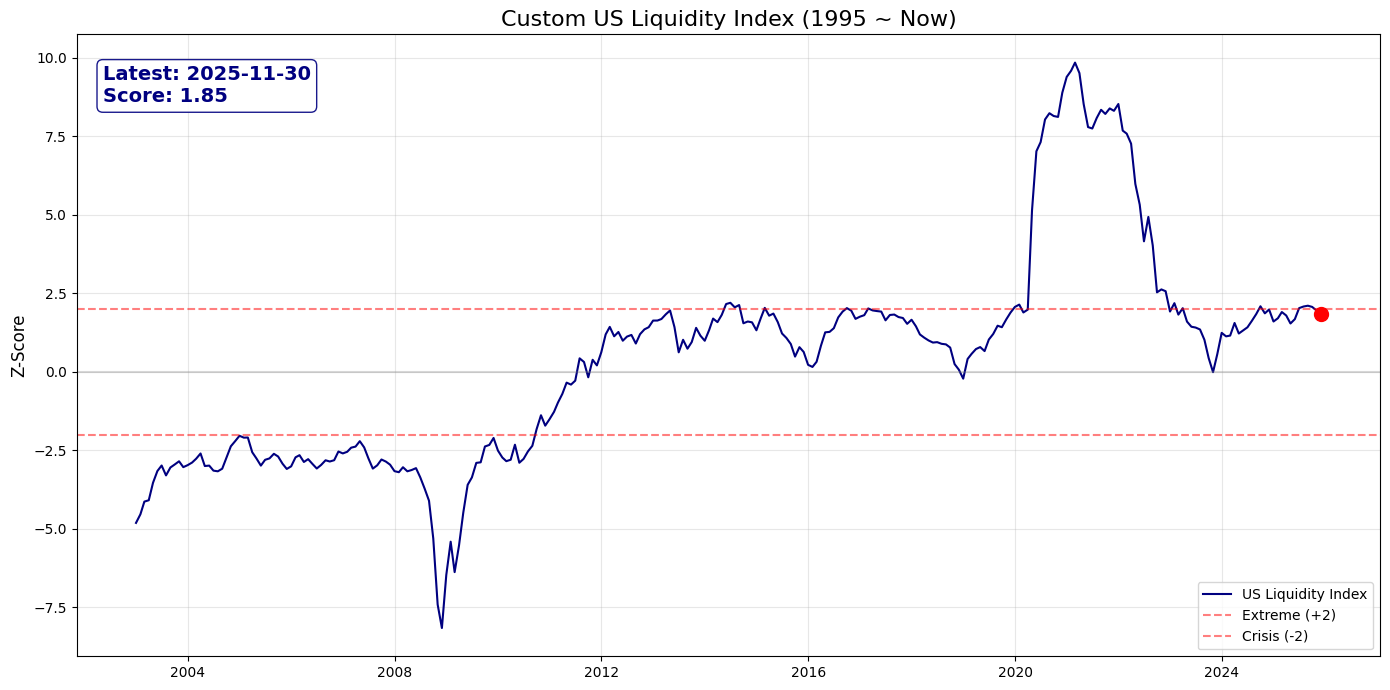

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# 1. 데이터 가져오기 (FRED API)
# 기간: 1994년부터 오늘까지
start = datetime.datetime(1994, 1, 1)
end = datetime.datetime.now()

# FRED 코드 설정
tickers = {
    'FedAssets': 'WALCL',       # 연준 총자산
    'M2': 'M2SL',               # M2 통화량
    'TGA': 'WTREGEN',           # 재무부 계좌
    'RRP': 'RRPONTSYD',         # 역레포
    'RealYield': 'DFII10',      # 10년물 실질금리
    'HY_Spread': 'BAMLH0A0HYM2' # 하이일드 스프레드
}

print("데이터를 불러오는 중입니다... 잠시만 기다려주세요.")

try:
    df = web.DataReader(list(tickers.values()), 'fred', start, end)
    df.columns = list(tickers.keys())

    # 데이터 전처리 (월말 기준 리샘플링 및 결측치 보정)
    df = df.resample('M').last().ffill()

    # 2. 파생 변수 및 지수 계산
    df['M2_YoY'] = df['M2'].pct_change(12)
    df['Net_Liquidity'] = df['FedAssets'] - df['TGA'].fillna(0) - df['RRP'].fillna(0)

    # Z-Score 함수
    def z_score(series):
        return (series - series.mean()) / series.std()

    # 유동성 지수 공식: (공급 + 확산 + 가용) - (비용 + 위험)
    df['Liquidity_Index'] = (
        z_score(df['FedAssets']) +
        z_score(df['M2_YoY']) +
        z_score(df['Net_Liquidity'])
    ) - (
        z_score(df['RealYield'].fillna(method='bfill')) +
        z_score(df['HY_Spread'])
    )

    # 3. 최신 값 추출 (차트 표시용)
    last_date = df.index[-1]
    last_value = df['Liquidity_Index'].iloc[-1]

    # 텍스트 포맷팅 (예: 2024-11-29 : +1.23)
    info_text = f"Latest: {last_date.strftime('%Y-%m-%d')}\nScore: {last_value:.2f}"

    # 4. 시각화 및 저장
    plt.figure(figsize=(14, 7)) # 차트 크기 확대

    # 메인 차트 그리기
    plt.plot(df.index, df['Liquidity_Index'], label='US Liquidity Index', color='navy', linewidth=1.5)

    # 기준선 (Thresholds)
    plt.axhline(2, color='red', linestyle='--', alpha=0.5, label='Extreme (+2)')
    plt.axhline(0, color='gray', linestyle='-', alpha=0.3)
    plt.axhline(-2, color='red', linestyle='--', alpha=0.5, label='Crisis (-2)')

    # [추가 기능 1] 최신 값 차트에 표시 (빨간 점 + 텍스트 박스)
    plt.scatter(last_date, last_value, color='red', s=100, zorder=5) # 빨간 점

    # 텍스트 박스 위치 및 스타일 설정
    props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='navy')
    plt.text(0.02, 0.95, info_text, transform=plt.gca().transAxes, fontsize=14,
             verticalalignment='top', bbox=props, color='navy', fontweight='bold')

    plt.title('Custom US Liquidity Index (1995 ~ Now)', fontsize=16)
    plt.ylabel('Z-Score', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # [추가 기능 2] 이미지 파일로 저장 (다운로드와 동일한 효과)
    filename = "Liquidity_Index_Latest.png"
    plt.savefig(filename, dpi=300) # 고화질 저장
    print(f"✅ 차트가 '{filename}' 파일로 저장되었습니다.")

    plt.show()

    # (구글 코랩 사용 시) 브라우저 다운로드 팝업 띄우기
    try:
        from google.colab import files
        files.download(filename)
    except ImportError:
        pass # 코랩이 아니면 패스

except Exception as e:
    print(f"오류 발생: {e}")
    print("pip install pandas_datareader matplotlib 명령어로 라이브러리를 설치했는지 확인해주세요.")
